<a href="https://colab.research.google.com/github/araldi/HS22_Big-Data-analysis-in-Biomedical-Research/blob/main/Week_09/16_Survival_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install a useful package for survival

https://lifelines.readthedocs.io/en/latest/

In [2]:
pip install lifelines

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 349 kB 3.7 MB/s 
     |████████████████████████████████| 77 kB 5.6 MB/s 
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4049 sha256=e3e57ed14f492bc434f94c2be166b4a0a7c9302375f5183b0977b4732941845f
  Stored in directory: /root/.cache/pip/wheels/9f/01/ee/1331593abb5725ff7d8c1333aee93a50a1c29d6ddda9665c9f
Successfully built autograd-gamma
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.1.1
    Uninstalling typing-extensions-4.1.1:
      Successfully uninstalled typing-extensions-4.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.1.5 requires typing-extensions<4.2.0,>=3.7.4.1; python_version < "3.8", but you have typing-extensions 

In [3]:
from lifelines.datasets import load_waltons
# load a test dataset for survival
df = load_waltons()

'''
Genotypes (mir-137 and control) and number of days survived in Drosophila (fruit). 

This is a good example of data that is not left-censored, although sometimes it is right-censored.

Since it is a flies dataset, we don’t need to worry about left-censoring (the exclusion of individuals that have not survived until the date of analysis). 
We know the birth date of all flies. 

There is the issues with accidentally killing some or if some escape. 
These would be right-censored as we do not actually observe their death due to “natural” causes.


'''

#### Data exploration

In [ ]:
df['group'].value_counts()

control    129
miR-137     34
Name: group, dtype: int64

Text(0, 0.5, 'instances')

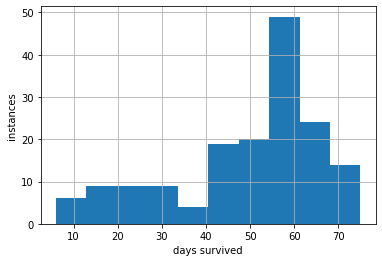

In [7]:
import matplotlib.pyplot as plt

# T is the time at censoring
df['T'].hist()
plt.xlabel('days survived')
plt.ylabel('instances')

In [ ]:
# E = whether the event (in this case death) has been observed (1) or not (0, right-censored data)
df['E'].value_counts()

1    156
0      7
Name: E, dtype: int64

In [ ]:
df

,T,E,group
0,6.0,1,miR-137
1,13.0,1,miR-137
2,13.0,1,miR-137
3,13.0,1,miR-137
4,19.0,1,miR-137
...,...,...,...
158,60.0,1,control
159,60.0,1,control
160,60.0,1,control
161,60.0,1,control


# Kaplan-Meier curve and estimate

A univariate model to determine survival over time.

Text(0, 0.5, 'Survival probability')

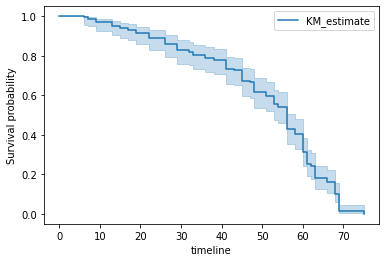

In [8]:
# Survival plot for the whole dataset

from lifelines import KaplanMeierFitter

kmf = KaplanMeierFitter()

kmf.fit(df['T'], event_observed=df['E'])
kmf.plot_survival_function()
plt.ylabel('Survival probability')


Text(0, 0.5, 'Survival probability')

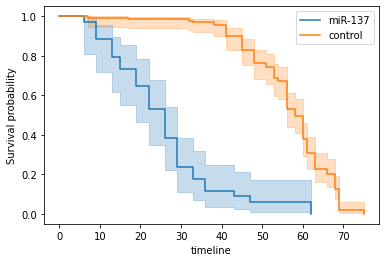

In [ ]:
# survival plot for each group

from lifelines import KaplanMeierFitter
kmf = {}
for i in df['group'].unique():
  kmf[i] = KaplanMeierFitter()
  df1 = df[df['group'] == i]
  kmf[i].fit(df1['T'], event_observed=df1['E'])
  kmf[i].plot_survival_function(label = i)


plt.ylabel('Survival probability')

In [9]:
# determine whether survival in control and miR-137 flies is different

from lifelines.statistics import logrank_test
ctrl = df['group'] == 'control'
results = logrank_test(df[ctrl]['T'], df[~ctrl]['T'], df[ctrl]['E'], df[~ctrl]['E'], alpha=.99)

results.print_summary()
# the two populations of flies differ significantly in their survival

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.99
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         122.25 <0.005     91.99

# Cox proportional hazard model

The idea behind Cox’s proportional hazard model is that the log-hazard of an individual is a linear function of their covariates and a population-level baseline hazard that changes over time.

In [13]:
# let's load an appropriate dataset
from lifelines.datasets import load_rossi
rossi_dataset = load_rossi()
'''
This data set is originally from Rossi et al. (1980). 
The data pertain to 432 convicts who were released from Maryland state prisons in the 1970s 
and who were followed up for one year after release. 
Half the released convicts were assigned at random to an experimental treatment (wexp) in which they were given financial aid; 
half did not receive aid.'''

In [14]:
rossi_dataset

# week is the time at event (T, or duration)
# arrest is the observed event (0 - arrest did not happen, 1 - arrest happened)
# all the other columns are features in the model. In particular:
'''
* fin, a factor with levels yes if the convict received financial aid and no if he did not.
* age, the convict’s age in years at the time of release
* race, the convict’s race, a factor with levels black and other
* wexp, the convict’s full-time work experience prior to incarceration, a factor coded no
or yes
* mar, the convict’s marital status at the time of release, a factor coded married or not
married
* paro, whether or not the convict was released on parole, a factored coded no or yes.
* prio, the number of convictions prior to the current conviction
* educ, level of education, coded numerically: 2 = 6th grade or less; 3 = 7th to 9th grade;
4 = 10th to 11th grade; 5 = 12th grade; and 6 = some college
* emp1, employment status in the first week after release, a factor with levels no and yes.
''' 

,week,arrest,fin,age,race,wexp,mar,paro,prio
0,20,1,0,27,1,0,0,1,3
1,17,1,0,18,1,0,0,1,8
2,25,1,0,19,0,1,0,1,13
3,52,0,1,23,1,1,1,1,1
4,52,0,0,19,0,1,0,1,3
...,...,...,...,...,...,...,...,...,...
427,52,0,1,31,0,1,0,1,3
428,52,0,0,20,1,0,0,1,1
429,52,0,1,20,1,1,1,1,1
430,52,0,0,29,1,1,0,1,3


In [15]:
from lifelines import CoxPHFitter

cph = CoxPHFitter()
cph.fit(rossi_dataset, duration_col='week', event_col='arrest')
cph.print_summary()  

# The treatment (fin), barely reaches significance, but it is less prominent than other factors, 
# such as age or priors

<lifelines.CoxPHFitter: fitted with 432 total observations, 318 right-censored observations>
             duration col = 'week'
                event col = 'arrest'
      baseline estimation = breslow
   number of observations = 432
number of events observed = 114
   partial log-likelihood = -658.75
         time fit was run = 2022-11-15 18:49:03 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
fin        -0.38       0.68       0.19            -0.75            -0.00                 0.47                 1.00
age        -0.06       0.94       0.02            -0.10            -0.01                 0.90                 0.99
race        0.31       1.37       0.31            -0.29             0.92                 0.75                 2.50
wexp       -0.15       0.86       0.21            -0.57             0.27                 0.57                 1.30
mar        -0.43       0.65       0.38            -1.18             0.31                 0.31                 1.37
paro       -0.08       0.92       0.20            -0.47             0.30                 0.63                 1.35
prio        0.09       1.10       0.03             0.04             0.15                 1.04                 1.16

            cmp to     z      p   -log2(p)
covariate                                 
fin           0.00 -1.98   0.05       4.40
age           0.00 -2.61   0.01       6.79
race          0.00  1.02   0.31       1.70
wexp          0.00 -0.71   0.48       1.06
mar           0.00 -1.14   0.26       1.97
paro          0.00 -0.43   0.66       0.59
prio          0.00  3.19 <0.005       9.48
---
Concordance = 0.64
Partial AIC = 1331.50
log-likelihood ratio test = 33.27 on 7 df
-log2(p) of ll-ratio test = 15.37

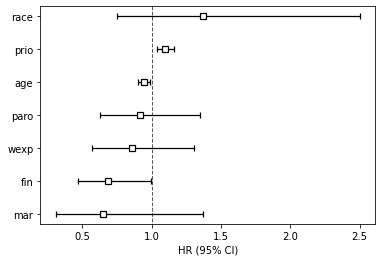

In [17]:
# draw a plot of the importance of each feature in contributing to the Hazard Ratio (or logHR)
cph.plot(hazard_ratios = True)

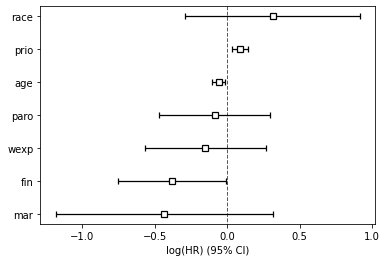

In [18]:
# draw a plot of the importance of each feature in contributing to the logHR
cph.plot(hazard_ratios = False)

Text(0, 0.5, 'Survival from arrest')

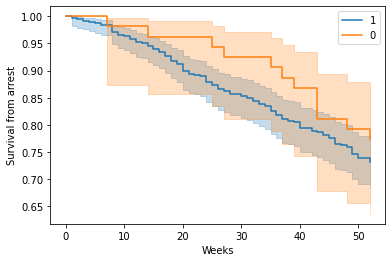

In [24]:
# Plot the dataset subgrouped into features (race in this case)
from lifelines import KaplanMeierFitter
kmf = {}
for i in rossi_dataset['race'].unique():
  kmf[i] = KaplanMeierFitter()
  df1 = rossi_dataset[rossi_dataset['race'] == i]
  kmf[i].fit(df1['week'], event_observed=df1['arrest'])
  kmf[i].plot_survival_function(label = i)

plt.xlabel('Weeks')
plt.ylabel('Survival from arrest')

Text(0, 0.5, 'Survival from arrest')

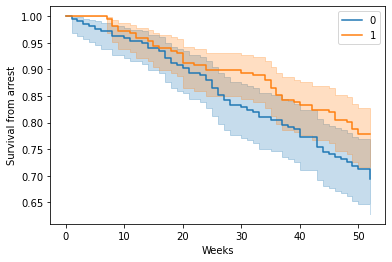

In [25]:
# Plot the dataset subgrouped into features (financial aid in this case)
from lifelines import KaplanMeierFitter
kmf = {}
for i in rossi_dataset['fin'].unique():
  kmf[i] = KaplanMeierFitter()
  df1 = rossi_dataset[rossi_dataset['fin'] == i]
  kmf[i].fit(df1['week'], event_observed=df1['arrest'])
  kmf[i].plot_survival_function(label = i)
plt.xlabel('Weeks')
plt.ylabel('Survival from arrest')

Text(0, 0.5, 'Istances')

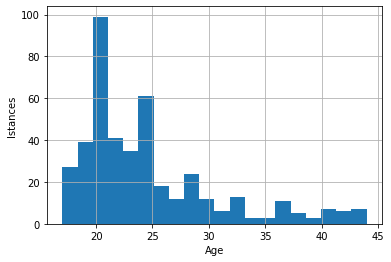

In [27]:
# Plot the dataset subgrouped into features (age in this case)

rossi_dataset['age'].hist(bins = 20)
plt.xlabel('Age')
plt.ylabel('Istances')

Text(0, 0.5, 'Survival from arrest')

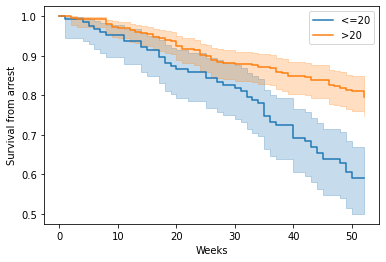

In [28]:
# Plot the dataset subgrouped into features (age in this case)

kmf = {}
age = 20
age_label = '<=%s' %age
kmf[age_label] = KaplanMeierFitter()
df1 = rossi_dataset[rossi_dataset['age'] <= age]
kmf[age_label].fit(df1['week'], event_observed=df1['arrest'])
kmf[age_label].plot_survival_function(label = age_label)


age_label = '>%s' %age
kmf[age_label] = KaplanMeierFitter()
df1 = rossi_dataset[rossi_dataset['age'] > age]
kmf[age_label].fit(df1['week'], event_observed=df1['arrest'])
kmf[age_label].plot_survival_function(label = age_label)

plt.xlabel('Weeks')
plt.ylabel('Survival from arrest')

Text(0, 0.5, 'Instances')

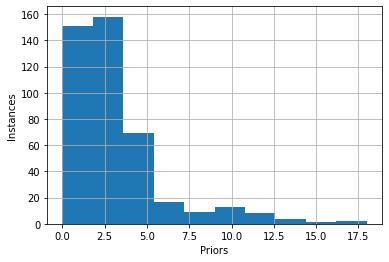

In [29]:
# Plot the dataset subgrouped into features (priors in this case)

rossi_dataset['prio'].hist()
plt.xlabel('Priors')
plt.ylabel('Instances')

In [ ]:
rossi_dataset['prio'].describe()

count    432.000000
mean       2.983796
std        2.896068
min        0.000000
25%        1.000000
50%        2.000000
75%        4.000000
max       18.000000
Name: prio, dtype: float64

Text(0.5, 0, 'Weeks')

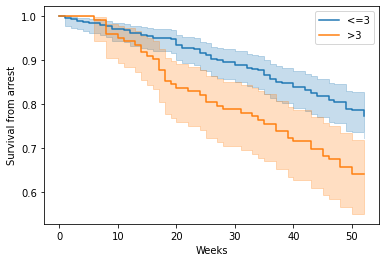

In [30]:

kmf = {}
prio = 3
prio_label = '<=%s' %prio
kmf[prio_label] = KaplanMeierFitter()
df1 = rossi_dataset[rossi_dataset['prio'] <= prio]
kmf[prio_label].fit(df1['week'], event_observed=df1['arrest'])
kmf[prio_label].plot_survival_function(label = prio_label)


prio_label = '>%s' %prio
kmf[prio_label] = KaplanMeierFitter()
df1 = rossi_dataset[rossi_dataset['prio'] > prio]
kmf[prio_label].fit(df1['week'], event_observed=df1['arrest'])
kmf[prio_label].plot_survival_function(label = prio_label)

plt.ylabel('Survival from arrest')
plt.xlabel('Weeks')